# Fine tuning BERT with tech keywords dataset

## 1.1. Set Up
First, we install and import the necessary modules and make sure GPU is available.

In [85]:
%pip install -q --upgrade transformers datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [86]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, DataLoader
from transformers import BertTokenizer, BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import DataCollatorForTokenClassification, DistilBertForTokenClassification, DistilBertTokenizerFast, pipeline

# Set display options to show the entire width
pd.set_option('display.max_colwidth', None)  # Show full width for each column
pd.set_option('display.max_rows', None)      # Show all rows without truncation
pd.set_option('display.max_columns', None)   # Show all columns without truncation

In [61]:
import torch

# Check if MPS is available (For MacOS only)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Example tensor operation
x = torch.randn(5, 3).to(device)  # Move tensor to GPU (MPS)
y = torch.randn(5, 3).to(device)  # Move another tensor to GPU

z = x + y  # Perform GPU-accelerated addition
print(z)

# Move result back to CPU if needed
z_cpu = z.to("cpu")
print(z_cpu)

tensor([[-0.2099,  0.4601,  0.8098],
        [ 2.0830, -0.5361,  0.3062],
        [ 0.3903, -1.9175,  1.1180],
        [-1.2585, -2.0618,  0.1686],
        [ 1.5663, -0.1358, -1.1732]], device='mps:0')
tensor([[-0.2099,  0.4601,  0.8098],
        [ 2.0830, -0.5361,  0.3062],
        [ 0.3903, -1.9175,  1.1180],
        [-1.2585, -2.0618,  0.1686],
        [ 1.5663, -0.1358, -1.1732]])


Since we have GPU available using MPS, we will be fine-tuning our model using GPU.

## 1.2. Download and Prepare Data
We will use the tech keywords dataset from HuggingFace and calling it using Pandas.

The dataset is separated into Train-Validation-Test sets.

In [8]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_dataset = pd.read_parquet("hf://datasets/ilsilfverskiold/tech-keywords-topics-summary/" + splits["train"])
train_dataset.head()

id                      source  \
0     appsmithorg-appsmith  github_trending_TypeScript   
1  38170237-CaffeinatedDev                  hackernews   
2             16a4f0f8afc7          medium_programming   
3             d443b087c2d0          medium_programming   
4             4cf4b6a0a0da          medium_programming   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  \
0  appsmith - Platform to build admin panels, internal tools, and dashboards. Integrates with 15+ databases and any API. - Organizations build internal applications such as dashboards, database GUIs, admin panels, approval apps, customer support dashboards, and more to help their teams perform day-to-day operations. Appsmith is an open-source tool that enables the rapid development of these internal apps. Read more on our website.InstallationThere are two ways to start using Appsmith:Signup on Appsmith Cloud.Ins   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                    Elon Musk went to camp where kids were encouraged to bully others for food/water   
2                                                                                                                                                                                                                                                                                                                                                                 Symfony Event System, Understanding and Implementing Event-driven Architecture - Explore real-world use cases and best practices for efficient software development   
3                                                                                                                                                                                                                                                                                                                                                                            Introduction To Swift Programming : Swift Cheat Sheet - A comprehensive Guide on Classes, Protocols, Extensions, Enums, Initializers, and Deinitializers   
4                                                                                                                                                                                                                                                                                                  10 Things You Didn’t Know About Famous Programmers Like Bill Gates and Mark Zuckerberg - As a programmer and tech enthusiast, I’m fascinated by the stories of how some of the most famous programmers and tech entrepreneurs got…   

                timestamp  reactions  engagement  \
0                    None      29386        3056   
1  2023-11-06 22:47:14+00          6           1   
2                    None         20           0   
3  2023-11-15 07:18:05+00         19           1   
4                    None         27           0   

                                                                                                                             url  \
0                                                                                        https://github

In [9]:
validation_dataset = pd.read_parquet("hf://datasets/ilsilfverskiold/tech-keywords-topics-summary/" + splits["validation"])
validation_dataset.head()

id                   source  \
0         38053465-wiserd               hackernews   
1            a29ec4af0678         medium_analytics   
2            0147435d2b13       medium_programming   
3            35750f675f6e  medium_machine-learning   
4  38268256-imheretolearn               hackernews   

                                                                                                                                                                                                              text  \
0                                                                                                                    Please be dying, but not too quickly, part 3: the end of the journeybessstillman.substack.com   
1                                   GoodData Plugins #3: Insight Groups - Enhance dashboard organization with GoodData’s Insight Groups plugin. Group multiple widgets for streamlined navigation and an improved…   
2                                                                                                                7.5 Ways To Use The Spread Operator In JavaScript. - Spread operator goes beyond spreading arrays   
3  Unveiling the Power of Plotly: 10 Essential Charts You Need to Know - Data visualization is crucial in data science projects as it allows effective communication of information. In Python, there are several…   
4                                                                                                                                                     Ask HN: CDK vs. Terraform – which one do you prefer and why?   

                timestamp  reactions  engagement  \
0  2023-10-28 21:18:50+00          4           3   
1  2023-11-16 08:15:00+00         22           0   
2                    None         20           0   
3  2023-11-10 06:04:41+00          2           0   
4  2023-11-14 19:26:21+00          5           7   

                                                                                                                     url  \
0                                                                          https://news.ycombinator.com/item?id=38053465   
1                                  https://medium.com/gooddata-developers/gooddata-plugins-3-insight-groups-a29ec4af0678   
2                                  https://dinma.medium.com/7-ways-to-use-the-spread-operator-in-javascript-0147435d2b13   
3  https://medium.datadriveninvestor.com/unveiling-the-power-of-plotly-10-essential-charts-you-need-to-know-35750f675f6e   
4                                                                          https://news.ycombinator.com/item?id=38268256   

   text_length                                                   keywords  \
0           93                                     Substack, Storytelling   
1          174  GoodData, Plugins, Insight Groups, Dashboard Organization   
2           97                                Spread Operator, JavaScript   
3          207                         Plotly, Data Visualization, Python   
4           60                                             CDK, Terraform   

                                      topic                       summary  \
0    Online Publishing, Personal Narratives            Substack Story End   
1  Data Visualization, Dashboard Management       GoodData Insight Groups   
2                       JavaScript Features          Spread operator uses   
3          Data Science, Data Visualization            Plotly chart guide   
4      Infrastructure as Code, DevOps Tools  CDK vs. Terraform Preference   

   __index_level_0__  
0               7939  
1               5002  
2                696  
3               8157  
4               6533

In [10]:
test_dataset = pd.read_parquet("hf://datasets/ilsilfverskiold/tech-keywords-topics-summary/" + splits["test"])
test_dataset.head()

id                      source  \
0                1430ee930e94     medium_machine-learning   
1          38158576-jruohonen                  hackernews   
2     38262115-nathan_phoenix                  hackernews   
3          38330991-transpute                  hackernews   
4  AprilNEA-ChatGPT-Admin-Web  github_trending_TypeScript   

                                                                                                                                                                                                                                                                                 text  \
0                                               Unleash the Edge: Women’s Faux Leather Zip-Up Motorcycle Jacket — Vintage Grunge Aesthetic Revived - Ride the Rebel Wave: Women’s Faux Leather Zip-Up Motorcycle Jacket — A Fusion of Timeless Edge and Vintage Grunge Aesthetic for…   
1                                                                                                                                                                                                                         Distractions, analytical thinking and falling for fake news   
2                                                                                                                                                                                                                    If you buy a Cybertruck, Tesla says you can't sell it for a year   
3                                                                                                                                                                                                     ODROID-M1S is a $49 single-board PC with RK3566, 64GB eMMC and an M.2 2280 slot   
4  ChatGPT-Admin-Web - One-stop system for shared use of AI within teams and organizationswith |  - English ChatGPT Admin Web CAW GitHub Sponsor / Features V3 V2 + topics: ai-system, chatgpt, gpt-4, llm, llvm, newbing, nextjs, postgresql, prisma, prompt, user-management, webui   

                timestamp  reactions  engagement  \
0                    None          4           0   
1  2023-11-06 03:40:49+00          3           0   
2  2023-11-14 11:47:06+00         27          64   
3  2023-11-19 09:48:25+00          4           0   
4  2023-11-17 09:11:00+00       2710        1185   

                                                                                                                                                  url  \
0  https://medium.com/global-trading-post/unleash-the-edge-womens-faux-leather-zip-up-motorcycle-jacket-vintage-grunge-aesthetic-revived-1430ee930e94   
1                                                                                                       https://news.ycombinator.com/item?id=38158576   
2                                                                                                       https://news.ycombinator.com/item?id=38262115   
3                                                                                                       https://news.ycombinator.com/item?id=38330991   
4                                                                                                       https://github.com/AprilNEA/ChatGPT-Admin-Web   

   text_length  \
0          229   
1           59   
2           64   
3           79   
4          295   

                                                                                                         keywords  \
0                                                Women's Fashion, Faux Leather, Motorcycle Jacket, Vintage Grunge   
1                                                                    Distractions, Analytical Thinking, Fake News   
2                                                                           Cybertruck, Tesla, Resale Restriction   
3                                                                   ODROID-M1S, RK3566, Single-Board PC, M.2 Slot   
4  ChatGPT-Admin-Web, AI, ChatGPT, GPT-4, LLM, 

In [11]:
# import string

# def label_keywords(row):
#     # Convert text and keywords to lowercase for case-insensitive comparison
#     text = row['text'].lower()
#     keywords = row['keywords'].lower()

#     # Remove punctuation from text and split into words
#     text = text.translate(str.maketrans('', '', string.punctuation)).split()

#     # Split keywords into individual words (space-separated within comma-separated phrases)
#     keywords = [keyword.split() for keyword in keywords.split(', ')]

#     labels = ['O'] * len(text)

#     for keyword_parts in keywords:
#         keyword_len = len(keyword_parts)
        
#         for i in range(len(text) - keyword_len + 1):
#             # Check if the keyword matches the portion of the text
#             if text[i:i + keyword_len] == keyword_parts:
#                 # Assign 'B-TEC' to the start of the keyword
#                 if i < len(labels):
#                     labels[i] = 'B-TEC'
                
#                 # Assign 'I-TEC' to the rest of the keyword parts
#                 for j in range(1, keyword_len):
#                     if i + j < len(labels):
#                         labels[i + j] = 'I-TEC'
#                 break  # Exit after the first match to avoid overwriting

#     return labels

In [12]:
import string

def label_keywords(row):
    # Convert text and keywords to lowercase for case-insensitive comparison
    text = row['text'].lower()
    keywords = row['keywords'].lower()

    # Remove punctuation from text and split into words
    text = text.translate(str.maketrans('', '', string.punctuation)).split()

    # Split keywords into individual words (space-separated within comma-separated phrases)
    keywords = [keyword.split() for keyword in keywords.split(', ')]

    labels = ['O'] * len(text)

    # Debugging: Print the processed text and keywords
    print(f"Text: {text}")
    print(f"Keywords: {keywords}")
    
    for keyword_parts in keywords:
        keyword_len = len(keyword_parts)
        
        # Debugging: Check for keyword match attempt
        print(f"Checking for keyword: {keyword_parts}")
        
        for i in range(len(text) - keyword_len + 1):
            # Check if the keyword matches the portion of the text
            if text[i:i + keyword_len] == keyword_parts:
                # Assign 'B-TEC' to the start of the keyword
                if i < len(labels):
                    labels[i] = 'B-TEC'
                
                # Assign 'I-TEC' to the rest of the keyword parts, ensuring indices don't exceed list bounds
                for j in range(1, keyword_len):
                    if i + j < len(labels):
                        labels[i + j] = 'I-TEC'
                
                print(f"Matched keyword: {keyword_parts} at position {i}")
    
    # Debugging: Print the resulting labels
    print(f"Labels: {labels}\n")
    
    return labels


# Apply the function to your dataset
train_dataset['labels'] = train_dataset.apply(label_keywords, axis=1).tolist()
validation_dataset['labels'] = validation_dataset.apply(label_keywords, axis=1).tolist()
test_dataset['labels'] = test_dataset.apply(label_keywords, axis=1).tolist()

Text: ['appsmith', 'platform', 'to', 'build', 'admin', 'panels', 'internal', 'tools', 'and', 'dashboards', 'integrates', 'with', '15', 'databases', 'and', 'any', 'api', 'organizations', 'build', 'internal', 'applications', 'such', 'as', 'dashboards', 'database', 'guis', 'admin', 'panels', 'approval', 'apps', 'customer', 'support', 'dashboards', 'and', 'more', 'to', 'help', 'their', 'teams', 'perform', 'daytoday', 'operations', 'appsmith', 'is', 'an', 'opensource', 'tool', 'that', 'enables', 'the', 'rapid', 'development', 'of', 'these', 'internal', 'apps', 'read', 'more', 'on', 'our', 'websiteinstallationthere', 'are', 'two', 'ways', 'to', 'start', 'using', 'appsmithsignup', 'on', 'appsmith', 'cloudins']
Keywords: [['appsmith'], ['admin', 'panels'], ['dashboards'], ['open', 'source'], ['internal', 'tools']]
Checking for keyword: ['appsmith']
Matched keyword: ['appsmith'] at position 0
Matched keyword: ['appsmith'] at position 42
Matched keyword: ['appsmith'] at position 69
Checking for 

In [13]:
import string
import pandas as pd

def preprocess_text(row):
    # Remove punctuation from text
    text = row['text']
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Check the type of each dataset
print("Type of train_dataset:", type(train_dataset))
print("Type of validation_dataset:", type(validation_dataset))
print("Type of test_dataset:", type(test_dataset))

# Convert to DataFrame if necessary
if isinstance(train_dataset, pd.Series):
    train_dataset = train_dataset.to_frame()
if isinstance(validation_dataset, pd.Series):
    validation_dataset = validation_dataset.to_frame()
if isinstance(test_dataset, pd.Series):
    test_dataset = test_dataset.to_frame()

# Check if the 'text' column exists in the DataFrames
print("Train dataset columns:", train_dataset.columns)
print("Validation dataset columns:", validation_dataset.columns)
print("Test dataset columns:", test_dataset.columns)

# Apply the function to your dataset
train_dataset['text'] = train_dataset.apply(preprocess_text, axis=1)
validation_dataset['text'] = validation_dataset.apply(preprocess_text, axis=1)
test_dataset['text'] = test_dataset.apply(preprocess_text, axis=1)

# Print a sample of the DataFrame to check
print(train_dataset[['text']].head())
print(validation_dataset[['text']].head())
print(test_dataset[['text']].head())

Type of train_dataset: <class 'pandas.core.frame.DataFrame'>
Type of validation_dataset: <class 'pandas.core.frame.DataFrame'>
Type of test_dataset: <class 'pandas.core.frame.DataFrame'>
Train dataset columns: Index(['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url',
       'text_length', 'keywords', 'topic', 'summary', '__index_level_0__',
       'labels'],
      dtype='object')
Validation dataset columns: Index(['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url',
       'text_length', 'keywords', 'topic', 'summary', '__index_level_0__',
       'labels'],
      dtype='object')
Test dataset columns: Index(['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url',
       'text_length', 'keywords', 'topic', 'summary', '__index_level_0__',
       'labels'],
      dtype='object')
                                                                                                                                                                 

In [15]:
# Print a sample of the DataFrame to check
print(train_dataset[['text', 'keywords', 'labels']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text  \
0  appsmith  Platform to build admin panels internal tools and dashboards Integrates with 15 databases and any API  Organizations build internal applications such as dashboards database GUIs admin panels approval apps customer support dashboards and more to help their teams perform daytoday operations Appsmith is an opensource tool that enables the rapid development of these internal apps Read more on our websiteInstallationThere are two ways to start using AppsmithSignup on Appsmith CloudIns  

In [16]:
# Print a sample of the DataFrame to check
print(validation_dataset[['text', 'keywords', 'labels']].head())

                                                                                                                                                                                                          text  \
0                                                                                                                     Please be dying but not too quickly part 3 the end of the journeybessstillmansubstackcom   
1                                   GoodData Plugins 3 Insight Groups  Enhance dashboard organization with GoodData’s Insight Groups plugin Group multiple widgets for streamlined navigation and an improved…   
2                                                                                                               75 Ways To Use The Spread Operator In JavaScript  Spread operator goes beyond spreading arrays   
3  Unveiling the Power of Plotly 10 Essential Charts You Need to Know  Data visualization is crucial in data science projects as it allows effective communicati

In [17]:
# Print a sample of the DataFrame to check
print(test_dataset[['text', 'keywords', 'labels']].head())

                                                                                                                                                                                                                                                          text  \
0                             Unleash the Edge Women’s Faux Leather ZipUp Motorcycle Jacket — Vintage Grunge Aesthetic Revived  Ride the Rebel Wave Women’s Faux Leather ZipUp Motorcycle Jacket — A Fusion of Timeless Edge and Vintage Grunge Aesthetic for…   
1                                                                                                                                                                                                   Distractions analytical thinking and falling for fake news   
2                                                                                                                                                                                               If you buy a Cybertruck Tesla says

In [18]:
train_dataset.iloc[41].text

'Create a SuperPrompt for Natural Language to SQL Conversion for OpenAI  One of the things that has changed more in recent months since the ChatGPT boom is the emergence of massive large language models able to…'

In [19]:
train_dataset.text.describe()

count                                                                                    7196
unique                                                                                   7174
top       Pebble the Twitter alternative previously known as T2 is shutting downtechcrunchcom
freq                                                                                        2
Name: text, dtype: object

In [20]:
train_dataset.iloc[41].labels

['O',
 'O',
 'B-TEC',
 'O',
 'O',
 'O',
 'O',
 'B-TEC',
 'O',
 'O',
 'B-TEC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-TEC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-TEC',
 'I-TEC',
 'I-TEC',
 'O',
 'O']

In [21]:
train_dataset.labels.describe()

count                               7196
unique                              6019
top       [O, O, O, O, O, O, O, O, O, O]
freq                                  26
Name: labels, dtype: object

In [22]:
# Since some of the rows contain only 'O' labels, we can filter them out
def contains_only_O(labels):
    return all(label == 'O' for label in labels)

# Apply the function and check for rows where 'labels' contains only 'O'
train_dataset_null = train_dataset[train_dataset['labels'].apply(contains_only_O)]
print("Number of rows with only 'O' tag is {:,} rows \n".format(len(train_dataset_null)))
print(train_dataset_null[['text', 'keywords', 'labels']].head())



Number of rows with only 'O' tag is 245 rows 

                                                                                text  \
5                       Sam BankmanFried Set to Testify at His Fraud Trialnytimescom   
60      Ask HN Tips for generating easy to remember but difficult to crack passwords   
67         Musks grandfathers political party – the world should be governed by tech   
79  Scientists find universal lower bound on topological entanglement entropyphysorg   
95     Show HN I am curating the best websites on the internetinternetisbeautifulcom   

                                     keywords  \
5         Sam Bankman-Fried, SBF, Fraud Trial   
60             Password Security, Hacker News   
67                     Elon Musk, Technocracy   
79  Topological Entanglement Entropy, Physics   
95    Curated Websites, Internet is Beautiful   

                                     labels  
5               [O, O, O, O, O, O, O, O, O]  
60  [O, O, O, O, O, O, O, O, O, O, O,

In [23]:
# Apply the function and filter out rows where 'labels' contains only 'O'
train_dataset_filtered = train_dataset[~train_dataset['labels'].apply(contains_only_O)]

# Reset the index after filtering, if needed
train_dataset_filtered.reset_index(drop=True, inplace=True)

# Print the remaining number of rows in the dataset after removal
print("Number of remaining rows in training sentences after filtering: {:,}\n".format(train_dataset_filtered.shape[0]))

# Print the filtered dataset
print(train_dataset_filtered[['text', 'keywords', 'labels']].head())

Number of remaining rows in training sentences after filtering: 6,951

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text  \
0  appsmith  Platform to build admin panels internal tools and dashboards Integrates with 15 databases and any API  Organizations build internal applications such as dashboards database GUIs admin panels approval apps customer support dashboards and more to help their teams perform daytoday operations Appsmith is an opensource tool that enables the rapid development of these internal apps Read more on our websiteInstallation

## 1.3. Exploratory Data Analysis (EDA)

Examine the dataset.

In [24]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_dataset.shape[0]))
print("Number of remaining rows in training sentences after filtering: {:,}\n".format(train_dataset_filtered.shape[0]))
print('Number of validation sentences: {:,}\n'.format(validation_dataset.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_dataset.shape[0]))

Number of training sentences: 7,196

Number of remaining rows in training sentences after filtering: 6,951

Number of validation sentences: 635

Number of test sentences: 635



In [25]:
train_dataset_filtered['text_length'] = train_dataset_filtered['text'].apply(lambda x: len(x.split()))
print("Examine the distribution of text lengths (number of words) in the filtered training dataset.")
train_dataset_filtered['text_length'].describe()

Examine the distribution of text lengths (number of words) in the filtered training dataset.


/var/folders/86/6d97n_7n0v5ckp3bz_00ycyw0000gn/T/ipykernel_42455/3879516045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_filtered['text_length'] = train_dataset_filtered['text'].apply(lambda x: len(x.split()))


count    6951.000000
mean       27.627679
std        23.749934
min         4.000000
25%        11.000000
50%        20.000000
75%        32.000000
max       179.000000
Name: text_length, dtype: float64

In [26]:
# Defining some key variables that will be used later on in the training
# To provide buffer for padding and avoid truncating long sentences, we set the max_length to twice the maximum length of the sentences.
MAX_LEN = 1.5*train_dataset_filtered['text_length'].max()
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

/Users/des/.pyenv/versions/3.10.0/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# Checking the max len
print(MAX_LEN)

268.5


Note: Since BERT has a maximum token length of 512, setting a max length of less than 300 will provide buffer while still complying to the limit.

We see that the shortest text has 3 words only, whereas the longest text has 182 words. 

To see the difference, we print out both the longest and shortest text.

In [28]:
print("Longest Text:")
print(train_dataset_filtered['text'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].max()].iloc[0])
print("Topic:")
print(train_dataset_filtered['topic'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].max()].iloc[0])
print("Keywords:")
print(train_dataset_filtered['keywords'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].max()].iloc[0])

Longest Text:
I keep reading that people with no coding skills are publishing their app ideas with the help of GPT How tf  And how can I do this I havent written a mobile app in atleast 7 years But even then you needed more than a stable code base GUI IampA svcDB Persistence AppStore mgmnt publishing monitoring etc Even the shitiest app will need most of these AI assistance has helped me a lot with coding and other questions recently I get it But only because I know when its giving me a good solution Its a lot of back and forth until you get something robust And if youre not familiar with certain concepts its like the blind leading the blind going through rabbit holes Can anyone tell me how someone with no dev experience can pull this off  I want to build a proof of concept app with as little effort as possible and utilize all these fancy new ai gadgetsBut I just dont understand how Id coerce an AI to write me an app and its environment 
Topic:
AI in App Development, No-code Solutions


In [29]:
print("Shortest Text:")
print(train_dataset_filtered['text'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].min()].iloc[0])
print("Topic:")
print(train_dataset_filtered['topic'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].min()].iloc[0])
print("Keywords:")
print(train_dataset_filtered['keywords'][train_dataset_filtered['text_length'] == train_dataset_filtered['text_length'].min()].iloc[0])

Shortest Text:
Disruptive Technologies from 2016jacobbartlettsubstackcom
Topic:
Tech Trends, Historical Analysis
Keywords:
Disruptive Technologies, 2016


In [94]:
labels_to_ids = {'B-TEC': 1, 
                 'I-TEC': 2, 
                 'O': 0}
labels_to_ids

{'B-TEC': 1, 'I-TEC': 2, 'O': 0}

In [95]:
ids_to_labels = { 1: 'B-TEC',
                 2: 'I-TEC', 
                 0: 'O'}
ids_to_labels

{1: 'B-TEC', 2: 'I-TEC', 0: 'O'}

In [34]:
# Convert the 'labels' column from a list to a tuple for deduplication
train_dataset_filtered['labels'] = train_dataset_filtered['labels'].apply(tuple)

# Now drop duplicates and reset the index
train_dataset_processed = train_dataset_filtered[["text", "labels"]].drop_duplicates().reset_index(drop=True)

# Print the first few rows to check
train_dataset_processed.head()


/var/folders/86/6d97n_7n0v5ckp3bz_00ycyw0000gn/T/ipykernel_42455/3992954201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_filtered['labels'] = train_dataset_filtered['labels'].apply(tuple)


text  \
0  appsmith  Platform to build admin panels internal tools and dashboards Integrates with 15 databases and any API  Organizations build internal applications such as dashboards database GUIs admin panels approval apps customer support dashboards and more to help their teams perform daytoday operations Appsmith is an opensource tool that enables the rapid development of these internal apps Read more on our websiteInstallationThere are two ways to start using AppsmithSignup on Appsmith CloudIns   
1                                                                                                                                                                                                                                                                                                                                                                                                                                 Elon Musk went to camp where kids were encouraged to bully others for foodwater   
2                                                                                                                                                                                                                                                                                                                                                 Symfony Event System Understanding and Implementing Eventdriven Architecture  Explore realworld use cases and best practices for efficient software development   
3                                                                                                                                                                                                                                                                                                                                                               Introduction To Swift Programming  Swift Cheat Sheet  A comprehensive Guide on Classes Protocols Extensions Enums Initializers and Deinitializers   
4                                                                                                                                                                                                                                                                                10 Things You Didn’t Know About Famous Programmers Like Bill Gates and Mark Zuckerberg  As a programmer and tech enthusiast I’m fascinated by the stories of how some of the most famous programmers and tech entrepreneurs got…   

                                                                                                                                                                                                                                                                  labels  
0  (B-TEC, O, O, O, B-TEC, I-TEC, B-TEC, I-TEC, O, B-TEC, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TEC, O, O, B-TEC, I-TEC, O, O, O, O, B-TEC, O, O, O, O, O, O, O, O, O, B-TEC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TEC, O)  
1                                                                                                                                                                                                                 (B-TEC, I-TEC, O, O, B-TEC, O, O, O, O, O, O, O, O, O)  
2                                                                                                                                                                                                  (B-TEC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TEC, I-TEC)  
3                                                                                                                                                                             (O, O, B-TEC, B-TEC, B-TEC, O, O, O, O, O, O, B-TEC, B-TEC, B-TEC, B-TEC, B-TEC, O, B-TEC)  
4                                                                                                                        (O, O, O, O, O, O, B-TEC, I-TE

In [35]:
# Convert the 'labels' column from a list to a tuple for deduplication
validation_dataset['labels'] = validation_dataset['labels'].apply(tuple)

# Now drop duplicates and reset the index
validation_dataset_processed = validation_dataset[["text", "labels"]].drop_duplicates().reset_index(drop=True)

# Print the first few rows to check
validation_dataset_processed.head()

text  \
0                                                                                                                     Please be dying but not too quickly part 3 the end of the journeybessstillmansubstackcom   
1                                   GoodData Plugins 3 Insight Groups  Enhance dashboard organization with GoodData’s Insight Groups plugin Group multiple widgets for streamlined navigation and an improved…   
2                                                                                                               75 Ways To Use The Spread Operator In JavaScript  Spread operator goes beyond spreading arrays   
3  Unveiling the Power of Plotly 10 Essential Charts You Need to Know  Data visualization is crucial in data science projects as it allows effective communication of information In Python there are several…   
4                                                                                                                                                    Ask HN CDK vs Terraform – which one do you prefer and why   

                                                                                                             labels  
0                                                                        (O, O, O, O, O, O, O, O, O, O, O, O, O, O)  
1                (B-TEC, B-TEC, O, B-TEC, I-TEC, O, B-TEC, I-TEC, O, O, B-TEC, I-TEC, O, O, O, O, O, O, O, O, O, O)  
2                                                 (O, O, O, O, O, B-TEC, I-TEC, O, B-TEC, B-TEC, I-TEC, O, O, O, O)  
3  (O, O, O, O, B-TEC, O, O, O, O, O, O, O, B-TEC, I-TEC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TEC, O, O, O)  
4                                                                   (O, O, B-TEC, O, B-TEC, O, O, O, O, O, O, O, O)

In [36]:
# Convert the 'labels' column from a list to a tuple for deduplication
test_dataset['labels'] = test_dataset['labels'].apply(tuple)

# Now drop duplicates and reset the index
test_dataset_processed = test_dataset[["text", "labels"]].drop_duplicates().reset_index(drop=True)

# Print the first few rows to check
test_dataset_processed.head()

text  \
0                             Unleash the Edge Women’s Faux Leather ZipUp Motorcycle Jacket — Vintage Grunge Aesthetic Revived  Ride the Rebel Wave Women’s Faux Leather ZipUp Motorcycle Jacket — A Fusion of Timeless Edge and Vintage Grunge Aesthetic for…   
1                                                                                                                                                                                                   Distractions analytical thinking and falling for fake news   
2                                                                                                                                                                                               If you buy a Cybertruck Tesla says you cant sell it for a year   
3                                                                                                                                                                                   ODROIDM1S is a 49 singleboard PC with RK3566 64GB eMMC and an M2 2280 slot   
4  ChatGPTAdminWeb  Onestop system for shared use of AI within teams and organizationswith    English ChatGPT Admin Web CAW GitHub Sponsor  Features V3 V2  topics aisystem chatgpt gpt4 llm llvm newbing nextjs postgresql prisma prompt usermanagement webui   

                                                                                                                                                      labels  
0  (O, O, O, O, B-TEC, I-TEC, O, B-TEC, I-TEC, O, B-TEC, I-TEC, O, O, O, O, O, O, O, B-TEC, I-TEC, O, B-TEC, I-TEC, O, O, O, O, O, O, O, B-TEC, I-TEC, O, O)  
1                                                                                                               (B-TEC, B-TEC, I-TEC, O, O, O, B-TEC, I-TEC)  
2                                                                                                         (O, O, O, O, B-TEC, B-TEC, O, O, O, O, O, O, O, O)  
3                                                                                                          (O, O, O, O, O, O, O, B-TEC, O, O, O, O, O, O, O)  
4              (O, O, O, O, O, O, O, B-TEC, O, O, O, O, O, B-TEC, O, O, O, O, O, O, O, O, O, O, B-TEC, O, B-TEC, B-TEC, B-TEC, O, B-TEC, B-TEC, O, O, B-TEC)

## 1.4. Prepare the dataset and model for fine-tuning

In [71]:
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, labels_to_ids):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.labels_to_ids = labels_to_ids

    def __getitem__(self, index):
        # Get the text and labels
        text = self.data.text.iloc[index]
        word_labels = self.data.labels.iloc[index]

        # Convert string labels to ids
        word_labels = [self.labels_to_ids[label] for label in word_labels]

        # Tokenize the text
        encoding = self.tokenizer(text.split(),
                                  is_split_into_words=True,
                                  return_offsets_mapping=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        # Create the labels for each token
        labels = []
        word_idx = 0
        for offset in encoding.offset_mapping:
            if offset[0] == 0 and offset[1] != 0:
                if word_idx < len(word_labels):
                    labels.append(word_labels[word_idx])
                    word_idx += 1
                else:
                    labels.append(-100)  # Use padding label if we've run out of word labels
            elif offset[0] == offset[1]:
                labels.append(-100)
            else:
                if word_idx < len(word_labels):
                    labels.append(word_labels[word_idx])
                else:
                    labels.append(-100)  # Use padding label if we've run out of word labels

        # Ensure labels list is the same length as the input_ids
        if len(labels) < len(encoding['input_ids']):
            labels.extend([-100] * (len(encoding['input_ids']) - len(labels)))
        elif len(labels) > len(encoding['input_ids']):
            labels = labels[:len(encoding['input_ids'])]

        # Convert to tensor
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(labels)

        return item

    def __len__(self):
        return self.len

# Set the maximum length for the input
MAX_LEN = int(1.5 * train_dataset_filtered['text_length'].max())

# Create datasets
train_dataset = CustomDataset(train_dataset_processed, tokenizer, MAX_LEN, labels_to_ids)
val_dataset = CustomDataset(validation_dataset_processed, tokenizer, MAX_LEN, labels_to_ids)
test_dataset = CustomDataset(test_dataset_processed, tokenizer, MAX_LEN, labels_to_ids)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize the model
model = BertForTokenClassification.from_pretrained(
    'dbmdz/bert-large-cased-finetuned-conll03-english', 
    num_labels=len(labels_to_ids),
    ignore_mismatched_sizes=True  # Add this parameter
)

print("Datasets and model prepared for fine-tuning.")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([3]) in the model instantia

Datasets and model prepared for fine-tuning.


## 1.5. Train the model to detect tech keywords as entity

In this section, we will finetune 'dbmdz/bert-large-cased-finetuned-conll03-english' model using the train_dataset that was prepared earlier.

Define the optimizer and learning rate scheduler.

In [72]:
from torch.optim import AdamW
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [73]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 3, but we'll see later that this may be over-fitting the training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

1302


In [74]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [75]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [76]:
import random
import numpy as np
import torch

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Check if MPS is available, if not fall back to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(seed_val)
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU instead.")

# Move the model to the appropriate device
model = model.to(device)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


In [77]:
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Unpack this training batch from our dataloader.
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()

        # Perform a forward pass
        try:
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        except RuntimeError as e:
            if "Placeholder storage has not been allocated on MPS device" in str(e):
                print("MPS device error encountered. Falling back to CPU.")
                device = torch.device("cpu")
                model.to(device)
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            else:
                raise e

        # Accumulate the training loss
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_loader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:

        # Unpack this training batch from our dataloader.
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            try:
                # Forward pass, calculate logit predictions.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            except RuntimeError as e:
                if "Placeholder storage has not been allocated on MPS device" in str(e):
                    print("MPS device error encountered. Falling back to CPU.")
                    device = torch.device("cpu")
                    model.to(device)
                    b_input_ids = b_input_ids.to(device)
                    b_input_mask = b_input_mask.to(device)
                    b_labels = b_labels.to(device)
                    outputs = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                else:
                    raise e

        # Accumulate the validation loss.
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        # Ensure that logits and label_ids have the same shape
        pred_flat = np.argmax(logits, axis=2).flatten()
        labels_flat = label_ids.flatten()
        
        # Truncate the longer array to match the length of the shorter one
        min_len = min(len(pred_flat), len(labels_flat))
        pred_flat = pred_flat[:min_len]
        labels_flat = labels_flat[:min_len]
        
        total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
        nb_eval_steps += 1
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / nb_eval_steps
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_loader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    434.    Elapsed: 0:00:52.
  Batch    80  of    434.    Elapsed: 0:01:47.
  Batch   120  of    434.    Elapsed: 0:02:44.
  Batch   160  of    434.    Elapsed: 0:04:02.
  Batch   200  of    434.    Elapsed: 0:06:25.
  Batch   240  of    434.    Elapsed: 0:08:05.
  Batch   280  of    434.    Elapsed: 0:09:32.
  Batch   320  of    434.    Elapsed: 0:10:48.
  Batch   360  of    434.    Elapsed: 0:11:48.
  Batch   400  of    434.    Elapsed: 0:13:32.

  Average training loss: 0.31
  Training epoch took: 0:16:23

Running Validation...
  Accuracy: 0.12
  Validation Loss: 0.24
  Validation took: 0:00:38

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    434.    Elapsed: 0:01:36.
  Batch    80  of    434.    Elapsed: 0:02:59.
  Batch   120  of    434.    Elapsed: 0:04:20.
  Batch   160  of    434.    Elapsed: 0:05:40.
  Batch   200  of    434.    Elapsed: 0:07:06.
  Batch   240  of    434.    Elapsed: 0:08:39.
  Batch  

In [78]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.30928988823418246,
  'Valid. Loss': 0.24453453235328199,
  'Valid. Accur.': 0.12374809192672995,
  'Training Time': '0:16:23',
  'Validation Time': '0:00:38'},
 {'epoch': 2,
  'Training Loss': 0.189381530688655,
  'Valid. Loss': 0.2405173197388649,
  'Valid. Accur.': 0.12470901882632293,
  'Training Time': '0:15:43',
  'Validation Time': '0:00:26'},
 {'epoch': 3,
  'Training Loss': 0.13420944905535143,
  'Valid. Loss': 0.25482045002281667,
  'Valid. Accur.': 0.1249332174355495,
  'Training Time': '0:15:45',
  'Validation Time': '0:00:32'}]

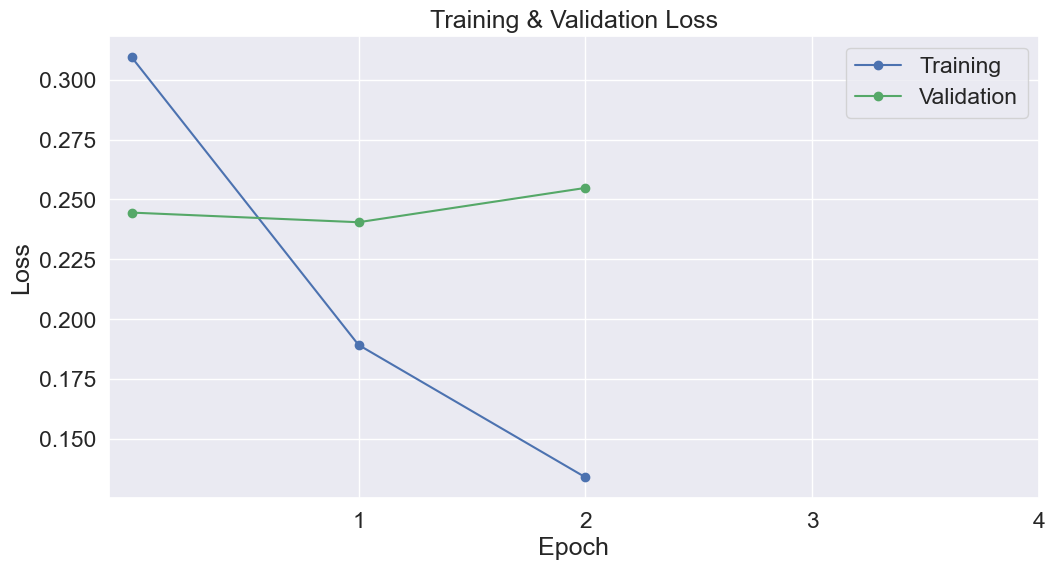

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 1.6. Test our model on its ability to detect tech keywords as entities

In [88]:
# ========================================
#               Testing
# ========================================

print("")
print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode
model.eval()

# Tracking variables 
total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

# Evaluate data for the test set
for batch in test_loader:

    # Unpack this test batch from our dataloader.
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        
        try:
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        except RuntimeError as e:
            if "Placeholder storage has not been allocated on MPS device" in str(e):
                print("MPS device error encountered. Falling back to CPU.")
                device = torch.device("cpu")
                model.to(device)
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            else:
                raise e

    # Accumulate the test loss.
    loss = outputs.loss
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    pred_flat = np.argmax(logits, axis=2).flatten()
    labels_flat = label_ids.flatten()
    
    # Truncate the longer array to match the length of the shorter one
    min_len = min(len(pred_flat), len(labels_flat))
    pred_flat = pred_flat[:min_len]
    labels_flat = labels_flat[:min_len]
    
    total_test_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
    nb_test_steps += 1

# Report the final accuracy for this test run.
avg_test_accuracy = total_test_accuracy / nb_test_steps
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_loader)

# Measure how long the test run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

# Record test statistics.
test_stats = {
    'Test Loss': avg_test_loss,
    'Test Accur.': avg_test_accuracy,
    'Test Time': test_time
}

print("Test stats:", test_stats)


Running Testing...
  Accuracy: 0.13
  Test Loss: 0.24
  Test took: 0:00:15
Test stats: {'Test Loss': 0.24262010417878627, 'Test Accur.': 0.1316554655698779, 'Test Time': '0:00:15'}


In [92]:
# Print 5 samples of the test results
print("Sample Test Results:")
for i, batch in enumerate(test_loader):
    if i >= 5:  # Only process the first 5 samples
        break
    
    # Unpack the batch
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    # Move input data to the same device as the model
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)
    labels = labels.to(model.device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Perform the prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get the predicted labels
    predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert predictions and true labels to label names
    predicted_labels = [[ids_to_labels[label.item()] for label in prediction[:30]] for prediction in predictions]
    true_labels = [[ids_to_labels[label.item()] if label.item() != -100 else 'PAD' for label in label_seq[:30]] for label_seq in labels]
    
    # Get the original tokens
    tokens = [tokenizer.convert_ids_to_tokens(input_id[:30]) for input_id in input_ids]
    
    # Print the results for this sample
    print(f"\nSample {i + 1}:")
    for token, pred_label, true_label in zip(tokens[0], predicted_labels[0], true_labels[0]):
        if token.startswith("##"):
            continue  # Skip subword tokens
        if pred_label != 'O' or true_label != 'O':
            print(f"Token: {token:<15} Predicted: {pred_label:<10} True: {true_label}")
    print("-" * 50)


Sample Test Results:

Sample 1:
Token: [CLS]           Predicted: O          True: PAD
Token: ’               Predicted: B-TEC      True: B-TEC
Token: s               Predicted: B-TEC      True: B-TEC
Token: F               Predicted: B-TEC      True: B-TEC
Token: Lea             Predicted: B-TEC      True: I-TEC
Token: Z               Predicted: B-TEC      True: O
Token: Motor           Predicted: B-TEC      True: B-TEC
Token: Jack            Predicted: I-TEC      True: I-TEC
Token: Vin             Predicted: B-TEC      True: B-TEC
Token: G               Predicted: I-TEC      True: I-TEC
--------------------------------------------------

Sample 2:
Token: [CLS]           Predicted: O          True: PAD
Token: session         Predicted: B-TEC      True: B-TEC
Token: Re              Predicted: B-TEC      True: B-TEC
Token: session         Predicted: B-TEC      True: B-TEC
--------------------------------------------------

Sample 3:
Token: [CLS]           Predicted: O          True: PAD

In [81]:
# Function to run the model on a sample string
def predict_technology(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Set the model to evaluation mode
    model.eval()
    
    # Perform the prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted labels
    predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert predictions to label names
    predicted_labels = [ids_to_labels[label.item()] for label in predictions[0]]
    
    # Combine the tokens and their predicted labels
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    result = list(zip(tokens, predicted_labels))
    
    return result

# Sample string to test the model
sample_text = "Apple released a new iPhone 16 with advanced AI capabilities."

# Run the prediction
prediction_result = predict_technology(sample_text)

# Print the results
print("Prediction Results:")
for token, label in prediction_result:
    if label != 'O':
        print(f"{token}: {label}")


Prediction Results:
Apple: B-TEC
iPhone: B-TEC
16: I-TEC
AI: B-TEC


From the sample output, we can see that the model is able to detect the keywords "iPhone" and "AI" as entities.

## 1.7. Saving the model

In [97]:
import os
import json

# Save the model checkpoint
output_dir = "./model_checkpoint"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
model.save_pretrained(output_dir)

# Save tokenizer
tokenizer.save_pretrained(output_dir)

# Save configuration
model.config.save_pretrained(output_dir)

# Save label mapping
with open(os.path.join(output_dir, "label_mapping.json"), "w") as f:
    json.dump(labels_to_ids, f)

print(f"Model checkpoint and artifacts saved to {output_dir}")


Model checkpoint and artifacts saved to ./model_checkpoint


In [82]:
#Saving your model.
output_file = "./model_bert_tech_ner.pth"

def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)


In [83]:
#In the future, to continue to work on this model, we can load it back in.
checkpoint = torch.load(output_file, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

/var/folders/86/6d97n_7n0v5ckp3bz_00ycyw0000gn/T/ipykernel_42455/3498183483.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(output_file, map_loca